In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
os.chdir("/Users/jakepappo/LocalDocuments/Stat288/Project")

### EuroSAT_MS Image Data and Metadata 

File Info:
- Number of bands: 13
- Width x Height: 64 x 64
- CRS: EPSG:32633
- Bounds: BoundingBox(left=547713.6708782589, bottom=6425702.312785538, right=548353.8421163161, top=6426342.401814095)
Image shape: (13, 64, 64)


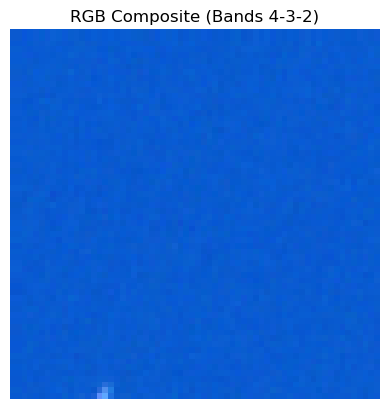

In [21]:
# File path
file_path = "EuroSAT_MS/SeaLake/SeaLake_1.tif"

# Open the file
with rasterio.open(file_path) as src:
    print("File Info:")
    print(f"- Number of bands: {src.count}")
    print(f"- Width x Height: {src.width} x {src.height}")
    print(f"- CRS: {src.crs}")
    print(f"- Bounds: {src.bounds}")
    
    # Read all bands (shape: [bands, height, width])
    img = src.read()

# Print array shape
print("Image shape:", img.shape)  # should be (13, 64, 64)

# Visualize RGB (bands 4, 3, 2 for Sentinel-2)
rgb = np.stack([img[3], img[2], img[1]], axis=-1)  # band 4=red, 3=green, 2=blue

# Normalize for display
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

# Show image
plt.imshow(rgb)
plt.title("RGB Composite (Bands 4-3-2)")
plt.axis("off")
plt.show()

In [22]:
import rasterio
from pyproj import Transformer
from geopy.geocoders import Nominatim

# Convert image center coordinates from CRS to lat/lon (WGS84)
def get_center_latlon(tif_path):
    with rasterio.open(tif_path) as src:
        bounds = src.bounds
        crs = src.crs  # Original CRS of the image
        x = (bounds.left + bounds.right) / 2
        y = (bounds.top + bounds.bottom) / 2
        
        # Set up transformer from image CRS to WGS84 (lat/lon)
        transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
        lon, lat = transformer.transform(x, y)
        return lat, lon

# Reverse geocode to get country
def get_country_from_coords(lat, lon):
    geolocator = Nominatim(user_agent="eurosat_country_lookup")
    try:
        location = geolocator.reverse((lat, lon), language='en', zoom=5)
        if location and 'country' in location.raw['address']:
            return location.raw['address']['country']
    except Exception as e:
        print(f"Reverse geocoding failed: {e}")
    return "Unknown"

# Run it
tif_file = "EuroSAT_MS/SeaLake/SeaLake_1.tif"
lat, lon = get_center_latlon(tif_file)
print(f"Latitude: {lat}, Longitude: {lon}")
country = get_country_from_coords(lat, lon)
print(f"Country: {country}")

Latitude: 57.97326587756279, Longitude: 15.812034061883649
Country: Sweden


### Non-Image Data

In [17]:
# Folder containing all the CSV files
csv_folder = "nonimage_data/var_csvs"

# Initialize an empty DataFrame with the country column
merged_df = None

# Loop through all .csv files in the folder
for filename in os.listdir(csv_folder):
    if filename.endswith(".csv"):
        filepath = os.path.join(csv_folder, filename)
        df = pd.read_csv(filepath)
        
        # Find the 2017 column(s)
        cols_2017 = df.columns[df.columns.str.contains("2017")].tolist()
        
        # If there is no 2017 column, skip
        if not cols_2017:
            continue
        
        # Use only the 'country' column and the 2017 column(s)
        df_2017 = df[["country"] + cols_2017].copy()
        
        # Rename 2017 column(s) to avoid duplicate column names
        for col in cols_2017:
            new_col_name = f"{os.path.splitext(filename)[0]}_{col}"
            df_2017 = df_2017.rename(columns={col: new_col_name})
        
        # Merge on 'country'
        if merged_df is None:
            merged_df = df_2017
        else:
            merged_df = pd.merge(merged_df, df_2017, on="country", how="outer")

# Show the merged DataFrame
merged_df.head()

,country,gdi_gdi_2017,gii_gii_2017,gnipc_gnipc_2017,abr_abr_2017,mmr_mmr_2017,mys_mys_2017,hdi_hdi_2017,co2_prod_co2_prod_2017,pop_total_pop_total_2017,le_le_2017
0,Afghanistan,0.696,0.681,2123.67648,90.342,681.807559,2.411230,0.485,0.276853,35.643417,63.016
1,Albania,0.966,0.145,12802.17590,16.585,6.689698,9.976700,0.796,1.838259,2.879355,79.047
2,Algeria,0.872,0.417,11633.27210,12.872,89.143542,7.086854,0.738,4.013210,41.136546,75.743
3,Andorra,NaN,NaN,54906.34820,6.404,NaN,10.732323,0.860,6.302125,0.073836,82.980
4,Angola,0.896,0.547,6772.54642,145.235,252.804854,5.521100,0.597,0.748693,30.208628,61.680


In [20]:
merged_df.to_csv("nonimage_data.csv")

In [ ]:
def load_country_data():
    # Directory containing CSV files
    data_dir = '/Users/jakepappo/LocalDocuments/Stat288/Project/nonimage_data/var_csvs'
    
    # Dictionary to store DataFrames
    country_data = {}
    
    # Load each CSV file
    for file in os.listdir(data_dir):
        if file.endswith('.csv'):
            name = file.split('.')[0]  # Remove .csv extension
            df = pd.read_csv(os.path.join(data_dir, file))
            country_data[name] = df
    
    return country_data

def merge_all_data(image_df, country_data):
    # Start with the image DataFrame that already has country information
    result = image_df.copy()
    
    # Merge with each country-specific dataset
    for metric_name, metric_df in country_data.items():
        result = result.merge(
            metric_df,
            on='country',  # Adjust this to match your actual country column name
            how='left',
            suffixes=('', f'_{metric_name}')
        )

Change path names so root is `EuroSAT_MS/`

In [6]:
df_all = pd.read_csv("eurosat/data/dataset_index.csv")
df_train = pd.read_csv("eurosat/data/train_index.csv")
df_test = pd.read_csv("eurosat/data/test_index.csv")
df_val = pd.read_csv("eurosat/data/val_index.csv")

In [5]:
df_all.head()

,image_path,label,latitude,longitude,country,country_Akrotiri Sovereign Base Area,country_Austria,country_Belgium,country_Bulgaria,country_Cyprus,...,gdi_2017,gii_2017,gnipc_2017,abr_2017,mmr_2017,mys_2017,hdi_2017,co2_prod_2017,pop_total_2017,le_2017
0,/Users/jakepappo/LocalDocuments/Stat288/Projec...,Forest,54.856372,23.641102,Lithuania,0,0,0,0,0,...,1.021,0.133,32541.1649,12.459,8.034957,13.18839,0.878,4.574429,2.904450,75.440
1,/Users/jakepappo/LocalDocuments/Stat288/Projec...,Forest,48.244798,17.130751,Slovakia,0,0,0,0,0,...,0.996,0.193,29599.1479,26.932,4.792917,12.76618,0.857,6.639333,5.439417,77.219
2,/Users/jakepappo/LocalDocuments/Stat288/Projec...,Forest,47.896999,16.533918,Austria,0,1,0,0,0,...,0.966,0.072,53665.0267,6.991,5.144606,12.15912,0.914,7.912331,8.797496,81.639
3,/Users/jakepappo/LocalDocuments/Stat288/Projec...,Forest,48.984167,21.372763,Slovakia,0,0,0,0,0,...,0.996,0.193,29599.1479,26.932,4.792917,12.76618,0.857,6.639333,5.439417,77.219
4,/Users/jakepappo/LocalDocuments/Stat288/Projec...,Forest,48.249989,17.165984,Slovakia,0,0,0,0,0,...,0.996,0.193,29599.1479,26.932,4.792917,12.76618,0.857,6.639333,5.439417,77.219


In [11]:
df_all['image_path'] = df_all['image_path'].str.extract(r'(EuroSAT_MS/.*)')
df_train['image_path'] = df_train['image_path'].str.extract(r'(EuroSAT_MS/.*)')
df_test['image_path'] = df_test['image_path'].str.extract(r'(EuroSAT_MS/.*)')
df_val['image_path'] = df_val['image_path'].str.extract(r'(EuroSAT_MS/.*)')

In [13]:
df_all.to_csv("eurosat/data/dataset_index.csv")
df_train.to_csv("eurosat/data/train_index.csv")
df_test.to_csv("eurosat/data/test_index.csv")
df_val.to_csv("eurosat/data/val_index.csv")